# Análise Exploratória - Tendências de Vendas de Grãos

## Bibliotecas

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import psycopg2
from sqlalchemy import create_engine
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Importação de dados

In [38]:
user = "postgres"
password = "lfgr"
host = "localhost"
port = "5432"
database = "agromercantil"

# String de conexão
conn_str = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(conn_str)

# Nome das tabelas
tabelas = ["clientes", "pedidos", "produtos", "itens_pedido"]

# Criação dos DataFrames
try:
    df_clientes = pd.read_sql("SELECT * FROM clientes", engine)
    df_pedidos = pd.read_sql("SELECT * FROM pedidos", engine)
    df_produtos = pd.read_sql("SELECT * FROM produtos", engine)
    df_itens = pd.read_sql("SELECT * FROM itens_pedido", engine)

    print("✅ Dados carregados com sucesso!")
except Exception as e:
    print("❌ Erro ao buscar os dados:", e)

✅ Dados carregados com sucesso!


In [39]:
df_clientes.head()

,id_cliente,nome,data_cadastro
0,1,Agropecuária São Jorge,2024-01-10
1,2,Cooperativa do Vale,2024-02-05
2,3,Fazenda Boa Esperança,2024-03-12
3,4,Cerealista Nacional,2024-04-01
4,5,Comercial Agrícola Sul,2024-04-08


In [40]:
df_produtos.head()

,id_produto,nome,categoria,preco
0,1,Soja,Grãos,150.0
1,2,Milho,Grãos,90.0
2,3,Trigo,Grãos,110.0
3,4,Arroz,Grãos,95.0
4,5,Feijão,Grãos,180.0


In [41]:
df_pedidos.head()

,id_pedido,data_pedido,valor_total,id_cliente
0,1,2024-04-10,7500.0,1
1,2,2024-04-12,4500.0,2
2,3,2024-04-13,9900.0,3
3,4,2024-04-14,2850.0,4
4,5,2024-04-15,3600.0,5


In [42]:
df_itens.head()

,id_item,id_pedido,id_produto,quantidade,preco_unitario
0,1,1,1,50,150.0
1,2,1,2,20,90.0
2,3,2,3,30,110.0
3,4,2,4,10,95.0
4,5,3,1,60,150.0


### Criação de tabela única para análise exploratória

In [43]:
## Cruzar para buscar as informações dos clientes
df_clientes_pedidos = pd.merge(df_pedidos, df_clientes, on="id_cliente", how="inner")
df_clientes_pedidos.head()

,id_pedido,data_pedido,valor_total,id_cliente,nome,data_cadastro
0,1,2024-04-10,7500.0,1,Agropecuária São Jorge,2024-01-10
1,2,2024-04-12,4500.0,2,Cooperativa do Vale,2024-02-05
2,3,2024-04-13,9900.0,3,Fazenda Boa Esperança,2024-03-12
3,4,2024-04-14,2850.0,4,Cerealista Nacional,2024-04-01
4,5,2024-04-15,3600.0,5,Comercial Agrícola Sul,2024-04-08


In [44]:
## Cruzar para unificar as informações dos pedidos
df_pedidos_itens = pd.merge(df_clientes_pedidos, df_itens, on="id_pedido", how="inner")
df_pedidos_itens.head()

,id_pedido,data_pedido,valor_total,id_cliente,nome,data_cadastro,id_item,id_produto,quantidade,preco_unitario
0,1,2024-04-10,7500.0,1,Agropecuária São Jorge,2024-01-10,1,1,50,150.0
1,1,2024-04-10,7500.0,1,Agropecuária São Jorge,2024-01-10,2,2,20,90.0
2,1,2024-04-10,7500.0,1,Agropecuária São Jorge,2024-01-10,12,1,60,150.0
3,1,2024-04-10,7500.0,1,Agropecuária São Jorge,2024-01-10,13,2,30,90.0
4,2,2024-04-12,4500.0,2,Cooperativa do Vale,2024-02-05,3,3,30,110.0


In [45]:
# Unificar todos os cruzamentos em uma única tabela para facilitar as análises
df_total = pd.merge(df_pedidos_itens, df_produtos, on="id_produto", how="inner")
df_total.head()

,id_pedido,data_pedido,valor_total,id_cliente,nome_x,data_cadastro,id_item,id_produto,quantidade,preco_unitario,nome_y,categoria,preco
0,1,2024-04-10,7500.0,1,Agropecuária São Jorge,2024-01-10,1,1,50,150.0,Soja,Grãos,150.0
1,1,2024-04-10,7500.0,1,Agropecuária São Jorge,2024-01-10,2,2,20,90.0,Milho,Grãos,90.0
2,1,2024-04-10,7500.0,1,Agropecuária São Jorge,2024-01-10,12,1,60,150.0,Soja,Grãos,150.0
3,1,2024-04-10,7500.0,1,Agropecuária São Jorge,2024-01-10,13,2,30,90.0,Milho,Grãos,90.0
4,2,2024-04-12,4500.0,2,Cooperativa do Vale,2024-02-05,3,3,30,110.0,Trigo,Grãos,110.0


In [46]:
df_total = df_total.rename(columns={
    "nome_x": "nome_cliente",
    "nome_y": "produto"
})

## Análise Exploratória

### Visualizações por cliente

#### Faturamento

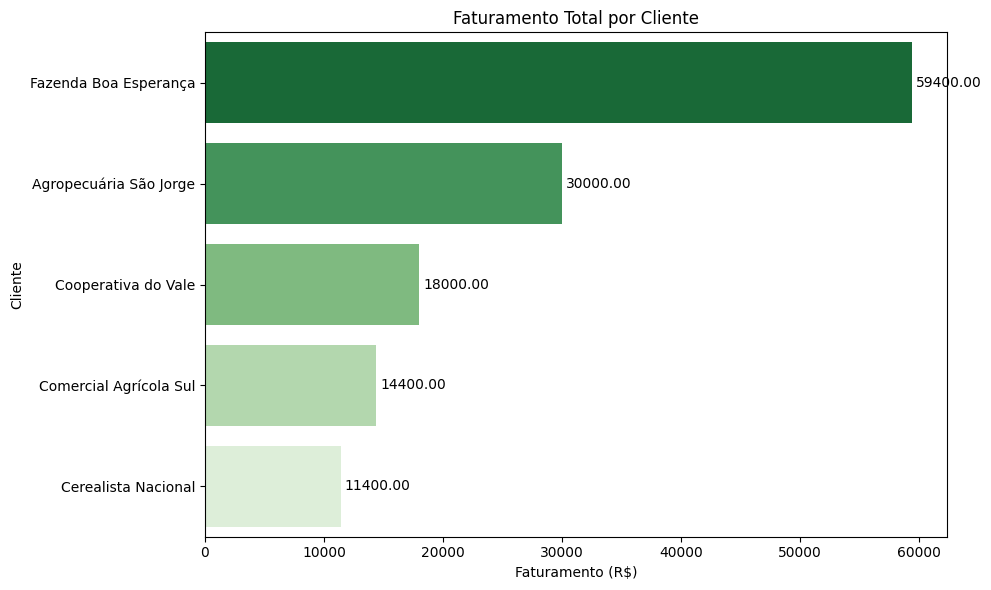

In [47]:
faturamento_por_cliente = df_total.groupby("nome_cliente")["valor_total"].sum().reset_index()
faturamento_por_cliente.columns = ["cliente", "faturamento_total"]
faturamento_por_cliente = faturamento_por_cliente.sort_values(by="faturamento_total", ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=faturamento_por_cliente, x="faturamento_total", y="cliente", palette="Greens_r")

for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', label_type='edge', padding=3)

plt.title("Faturamento Total por Cliente")
plt.xlabel("Faturamento (R$)")
plt.ylabel("Cliente")
plt.tight_layout()
plt.show()

#### Ticket médio

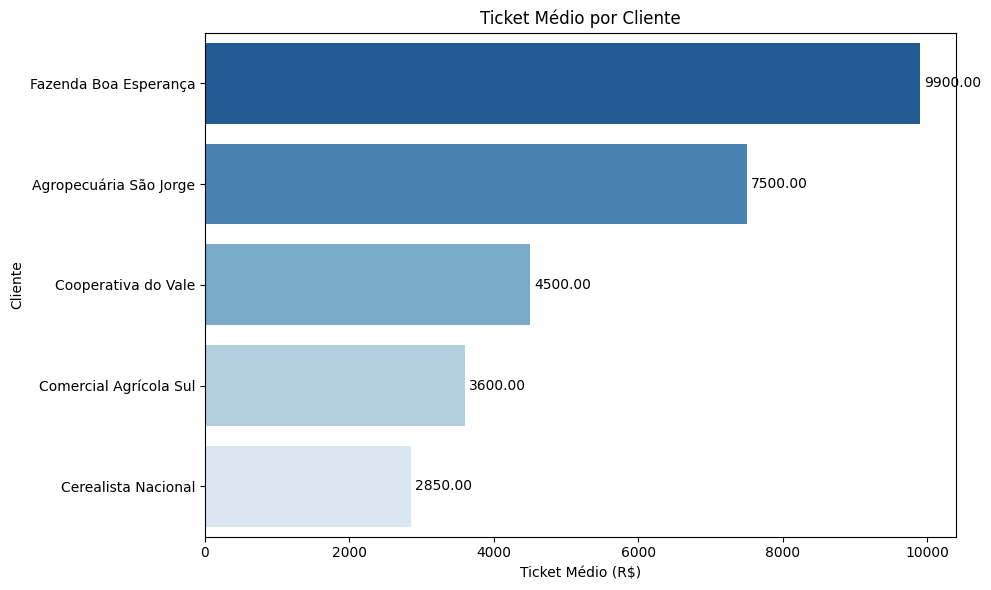

In [48]:
contagem_transacoes = df_total.groupby("nome_cliente").size().reset_index()
contagem_transacoes.columns = ["nome_cliente", "num_transacoes"]

ticket_medio = pd.merge(faturamento_por_cliente, contagem_transacoes,left_on="cliente", right_on="nome_cliente")

ticket_medio["ticket_medio"] = ticket_medio["faturamento_total"] / ticket_medio["num_transacoes"]

ticket_medio = ticket_medio.sort_values(by="ticket_medio", ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=ticket_medio, x="ticket_medio", y="cliente", palette="Blues_r")

for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', label_type='edge', padding=3)

plt.title("Ticket Médio por Cliente")
plt.xlabel("Ticket Médio (R$)")
plt.ylabel("Cliente")
plt.tight_layout()
plt.show()

O cliente Fazenda Boa esperança representa o maior faturamento e o maior Ticket Médio, mostrando que é um cliente essencial para o faturamento da empresa, pois além de ter um faturamento total alto, este está disposto a comprar produtos de maior preço.

### Visualizações gerais

In [49]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_pedido       22 non-null     int64  
 1   data_pedido     22 non-null     object 
 2   valor_total     22 non-null     float64
 3   id_cliente      22 non-null     int64  
 4   nome_cliente    22 non-null     object 
 5   data_cadastro   22 non-null     object 
 6   id_item         22 non-null     int64  
 7   id_produto      22 non-null     int64  
 8   quantidade      22 non-null     int64  
 9   preco_unitario  22 non-null     float64
 10  produto         22 non-null     object 
 11  categoria       22 non-null     object 
 12  preco           22 non-null     float64
dtypes: float64(3), int64(5), object(5)
memory usage: 2.4+ KB


In [50]:
# Estatísticas básicas
df_total.describe()

,id_pedido,valor_total,id_cliente,id_item,id_produto,quantidade,preco_unitario,preco
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,3.000000,6054.545455,3.000000,11.500000,3.636364,50.909091,119.090909,119.090909
std,1.380131,2861.272989,1.380131,6.493587,1.965063,36.795327,37.847953,37.847953
min,1.000000,2850.000000,1.000000,1.000000,1.000000,10.000000,70.000000,70.000000
25%,2.000000,3600.000000,2.000000,6.250000,2.000000,20.000000,91.250000,91.250000
50%,3.000000,4500.000000,3.000000,11.500000,4.000000,40.000000,100.000000,100.000000
75%,4.000000,9300.000000,4.000000,16.750000,5.000000,82.500000,150.000000,150.000000
max,5.000000,9900.000000,5.000000,22.000000,7.000000,120.000000,180.000000,180.000000


#### Histograma

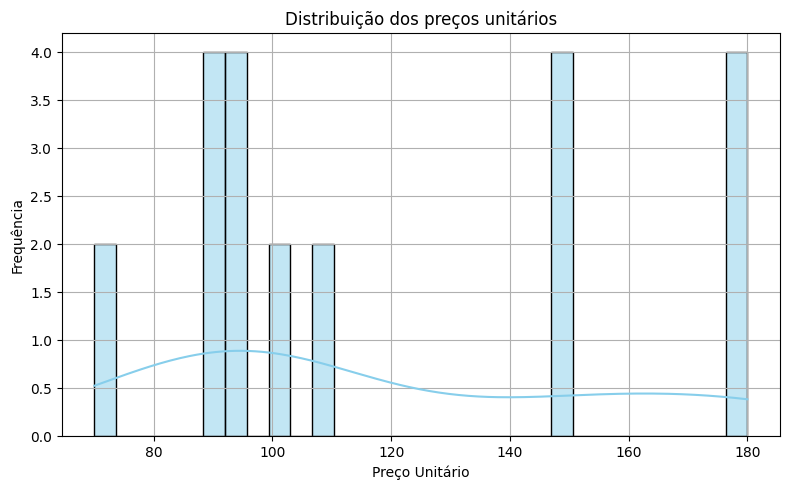

In [51]:
plt.figure(figsize=(8, 5))
sns.histplot(df_total["preco_unitario"], bins=30, kde=True, color="skyblue")
plt.title("Distribuição dos preços unitários")
plt.xlabel("Preço Unitário")
plt.ylabel("Frequência")
plt.grid(True)
plt.tight_layout()
plt.show()

A moda dos preços unitário está entre 90-95 e acima de 140 reais

#### Scatter-plot

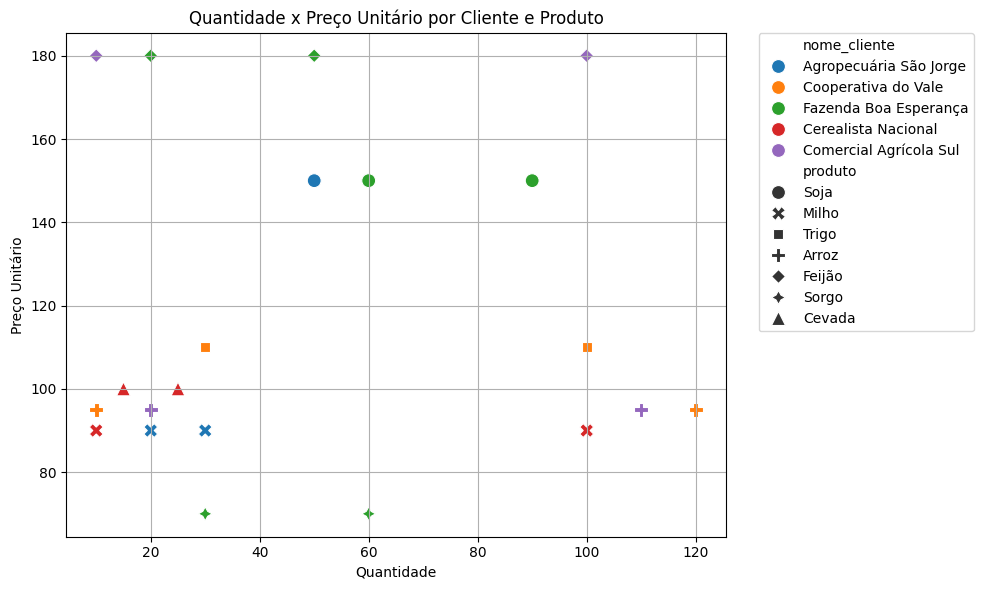

In [52]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df_total, x="quantidade", y="preco_unitario", hue="nome_cliente",style="produto",s=100)

plt.title("Quantidade x Preço Unitário por Cliente e Produto")
plt.xlabel("Quantidade")
plt.ylabel("Preço Unitário")
plt.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

#### Com base no gráfico acima, percebemos que:

Analisando o gráfico "Quantidade x Preço Unitário por Cliente e Produto", podemos fazer várias observações importantes:


- O feijão (representado por diamantes) tem o preço unitário mais alto, consistentemente em torno de R$ 180, independentemente da quantidade comprada.
- A soja (círculos) e alguns produtos da Fazenda Boa Esperança (verde) têm preços unitários na faixa intermediária (R$ 150).
- O milho e o Sorgo tem os preços unitários mais baixos
- A Comercial Agrícola Sul (roxo) e a Cooperativa do Vale (laranja) compram produtos com preços variados.
- A Fazenda Boa Esperança (verde) compra produtos de valor intermediário a alto.
- A Cerealista Nacional (vermelho) aparece comprando produtos com preços unitários mais baixos.


#### Box-plot

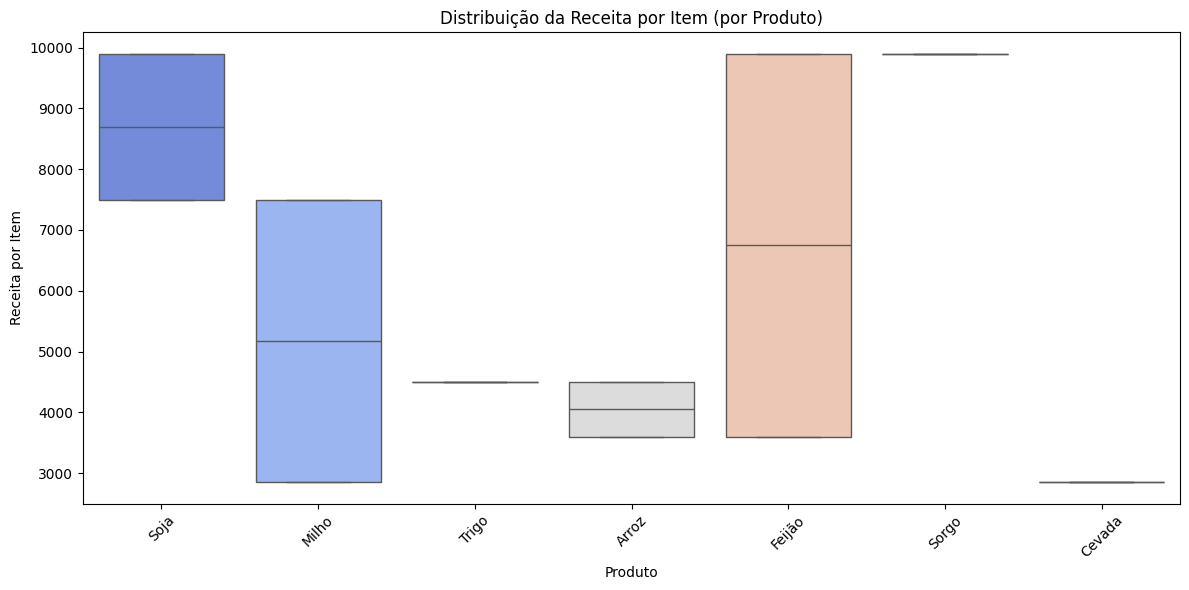

In [53]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_total, x="produto", y="valor_total", palette="coolwarm")
plt.title("Distribuição da Receita por Item (por Produto)")
plt.xticks(rotation=45)
plt.xlabel("Produto")
plt.ylabel("Receita por Item")
plt.tight_layout()
plt.show()

In [54]:
estatisticas_detalhadas = df_total.groupby('produto')['valor_total'].describe()

produtos = df_total['produto'].unique()
for produto in produtos:
    dados = df_total[df_total['produto'] == produto]['valor_total']
    Q1 = dados.quantile(0.25)
    Q3 = dados.quantile(0.75)
    IQR = Q3 - Q1
    
    limite_inferior = max(Q1 - 1.5 * IQR, dados.min())
    limite_superior = min(Q3 + 1.5 * IQR, dados.max())
    
    estatisticas_detalhadas.loc[produto, 'limite_inferior'] = limite_inferior
    estatisticas_detalhadas.loc[produto, 'limite_superior'] = limite_superior

colunas_ordenadas = ['count', 'mean', 'std', 'min', 'limite_inferior', '25%', '50%', '75%', 'limite_superior', 'max']
estatisticas_detalhadas = estatisticas_detalhadas[colunas_ordenadas].round(2)

print("Estatísticas Detalhadas por Produto:")
print(estatisticas_detalhadas)

Estatísticas Detalhadas por Produto:
         count    mean      std     min  limite_inferior     25%     50%  \
produto                                                                    
Arroz      4.0  4050.0   519.62  3600.0           3600.0  3600.0  4050.0   
Cevada     2.0  2850.0     0.00  2850.0           2850.0  2850.0  2850.0   
Feijão     4.0  6750.0  3637.31  3600.0           3600.0  3600.0  6750.0   
Milho      4.0  5175.0  2684.68  2850.0           2850.0  2850.0  5175.0   
Soja       4.0  8700.0  1385.64  7500.0           7500.0  7500.0  8700.0   
Sorgo      2.0  9900.0     0.00  9900.0           9900.0  9900.0  9900.0   
Trigo      2.0  4500.0     0.00  4500.0           4500.0  4500.0  4500.0   

            75%  limite_superior     max  
produto                                   
Arroz    4500.0           4500.0  4500.0  
Cevada   2850.0           2850.0  2850.0  
Feijão   9900.0           9900.0  9900.0  
Milho    7500.0           7500.0  7500.0  
Soja     9900.0     

O print acima trás todas as estatíscas detalhadas do box plot e de outras medidas importantes para o faturamento de cada produto

#### Correlação

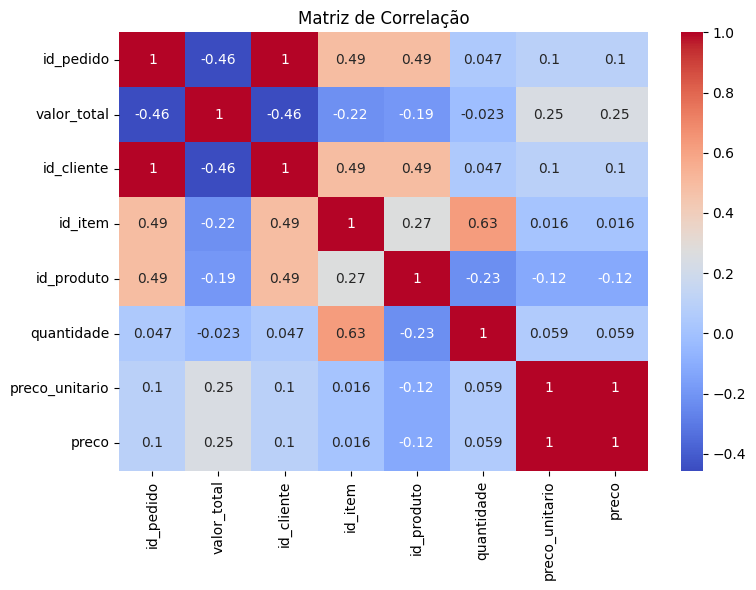

In [55]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_total.select_dtypes(include="number").corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.tight_layout()
plt.show()

A matriz de correlação é acima é calculada através da correlação de Pearson, onde siginifica:

- r > 0 -> Correlação positiva, ou seja, se o valor de x aumenta, o valor de y aumenta também;
- r < 0 -> Correlação negativa, ou seja, se o valor de x aumenta, o valor de y diminui;
- r = 0 -> Não existe correlação entre as duas variáveis.


#### Observações:


*Correlações Negativas Significativas*
- valor_total e id_pedido/id_cliente apresentam correlação negativa moderada (-0.46), o que é interessante e pode indicar que clientes com IDs mais altos (possivelmente clientes mais novos) tendem a fazer pedidos de menor valor, ou vice-versa.
- valor_total e id_produto tem correlação negativa fraca (-0.19), sugerindo uma leve tendência de produtos com IDs mais altos terem valores totais menores.

*Correlações Positivas Significativas*

- id_item e quantidade mostram correlação positiva forte (0.63), o que pode indicar que itens específicos são consistentemente comprados em maiores quantidades.
- id_pedido/id_cliente e id_item/id_produto têm correlação positiva moderada (0.49), sugerindo um padrão onde certos clientes tendem a comprar produtos específicos.

*Ausência de Correlações*

- quantidade e valor_total têm correlação quase nula (-0.023), o que é surpreendente, pois normalmente esperaríamos que maiores quantidades resultassem em maiores valores totais. Isso sugere que o preço unitário varia significativamente entre os produtos, compensando o efeito da quantidade.
- preco_unitario e quantidade têm correlação muito fraca (0.059), indicando que não há uma relação clara entre o preço unitário e a quantidade comprada (não há evidência forte de descontos por volume).